# Analyse results of DEPICT

Here we anlayse the results of the DEPICT algorithm on the set of Farashi et al.

In [1]:
# Load the required packages
import pandas as pd

In [2]:
#farashi = pd.read_csv("~/git/DEPICT/outcomes/Farashi complete 2nd round/farashi_no_pvalue_filtering_geneprioritization.txt", sep = "\t")
farashi = pd.read_csv("~/git/DEPICT/outcomes/Farashi complete 2nd round/farashi_default_pvalue_filtering_geneprioritization.txt", sep = "\t")

In [3]:
# Explode the listed genes in the candidates table
farashi["Locus"] = farashi["Locus"].astype(str).apply(lambda x: x.split(";"))
farashi = farashi.explode("Locus")

<AxesSubplot:>

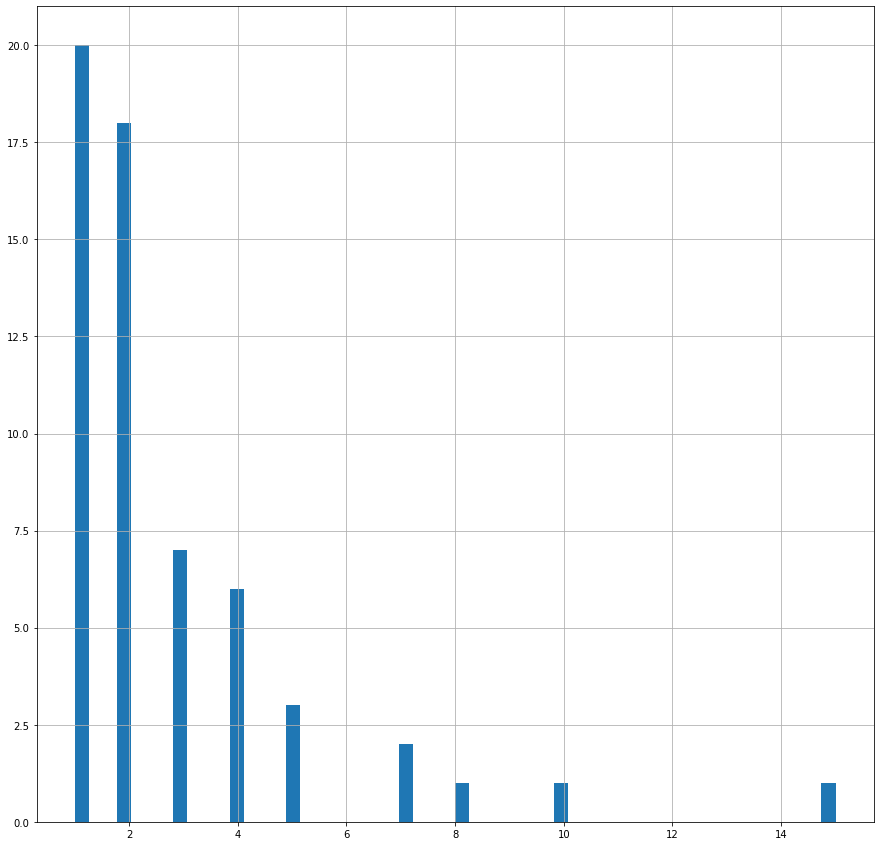

In [4]:
# Count how many candidate genes each SNP approximately has
farashi.groupby("Locus")["Ensembl gene ID"].nunique().hist(bins = 54, figsize = (15,15))

In [5]:
print("Mean number of candidates per SNP: " + str(farashi.groupby("Locus")["Ensembl gene ID"].nunique().mean().round(2)))

Mean number of candidates per SNP: 2.76


In [6]:
# Update the SNP ID's
snp_replacement_dict = {"rs113645266" : "rs6557271",
                        "rs150282463" : "rs13137700",
                        "rs67276543" : "rs34884832"}
farashi["Locus"] = farashi["Locus"].replace(snp_replacement_dict)

In [7]:
# Initiate the connection to the database (first time you may have to run ensembl.download() and ensembl.index())
# To align with our reference set, we take a Ensembl version from 2019
from pyensembl import EnsemblRelease
ensembl = EnsemblRelease(92)

# Function to extract the data (and prevent superfluous queries)
def getEnsemblData(id):
    try:
        data = ensembl.gene_by_id(id)
        return pd.Series({"gene name" : data.gene_name, 
                          "chromosome" : data.contig, 
                          "gene start" : data.start,
                          "gene stop" : data.end,
                          "protein_coding" : data.is_protein_coding})
    except ValueError:
        return pd.Series({"gene name" : None, 
                          "chromosome" : None, 
                          "gene start" : None,
                          "gene stop" : None,
                          "protein_coding" : None})

In [8]:
farashi[["gene name", "chromosome", "gene start", "gene stop", "protein_coding"]] = farashi["Ensembl gene ID"].apply(lambda x: getEnsemblData(x))

# Limit outcomes to protein coding genes only, for a fair comparison
farashi = farashi[farashi["protein_coding"] == True]

In [9]:
farashi_ref = pd.read_csv("/Users/vlietstraw/git/Post-GWAS/Input sets/Farashi/Farashi full 2000000 bp distance no pvalue filtering.csv")
farashi_ref = farashi_ref[farashi_ref["GWAS/eQTL p-value¥"] <= float("5e-8")]

In [10]:
farashi = farashi.merge(farashi_ref[["SNP ID", "gene_ids", "Class"]], left_on = ["Locus", "Ensembl gene ID"], right_on = ["SNP ID", "gene_ids"], how = "left")

In [11]:
positives = farashi.groupby("Locus")["Class"].sum()
positives = positives[positives > 0]
farashi = farashi[farashi["Locus"].isin(positives.index)]

In [12]:
# Bij Farashi kan dit. Er zijn wel gedupliceerde P-values, maar die zijn meestal 1, en eigenlijk nooit voor positieve cases
outcomes = farashi.sort_values(["Locus", "Nominal P value"], ascending = True)
outcomes["Rank"] = outcomes.groupby("SNP ID").cumcount() + 1

In [13]:
import sklearn.metrics

fpr, tpr, thresholds = sklearn.metrics.roc_curve(outcomes["Class"], -outcomes["Rank"], pos_label = 1)
overall_auc = sklearn.metrics.auc(fpr, tpr)
print(overall_auc)

0.7567774936061381


In [14]:
# Calculate the ROC-AUC for every SNP and average the result
SNPS2 = list(set(outcomes["Locus"]))
aucs = []
for snp in SNPS2:
    if len(set(outcomes["Class"][outcomes["Locus"] == snp])) == 1:
        aucs.append(list(set(outcomes["Class"][outcomes["Locus"] == snp]))[0])
    else:
        fpr, tpr, thresholds = sklearn.metrics.roc_curve(outcomes["Class"][outcomes["Locus"] == snp], -outcomes["Nominal P value"][outcomes["Locus"] == snp], pos_label = 1)
        aucs.append(sklearn.metrics.auc(fpr, tpr))
print(sum(aucs)/len(aucs))

0.7588768115942031


In [15]:
len(outcomes[(outcomes["Class"] == 1) & (outcomes["Rank"] == 1)])

30

In [16]:
len(outcomes[(outcomes["Class"] == 1) & (outcomes["Rank"] <= 3)])

41

In [17]:
len(outcomes[(outcomes["Class"] == 1) & (outcomes["Rank"] <= 5)])

44

In [18]:
len(outcomes[(outcomes["Class"] == 1) & (outcomes["Rank"] <= 10)])

46

In [19]:
len(set(outcomes["Locus"]))

46

In [20]:
sum(outcomes["Class"])

46

In [21]:
outcomes["Rank"][outcomes["Class"] == 1].mean()

1.8043478260869565

In [22]:
outcomes["Rank"][outcomes["Class"] == 1].median()

1.0